<a href="https://colab.research.google.com/github/bhumikakadbe/Unsupervised-learning/blob/main/Online_Retail_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import datetime as dt


# Step 2: Load Dataset


In [ ]:
file_path = "/content/online_retail_II.csv"  # Update this path to your local file
df = pd.read_csv(file_path, encoding='ISO-8859-1')


## Display basic info


In [ ]:
print("Initial Data Shape:", df.shape)
print(df.head())


Initial Data Shape: (1067371, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [ ]:
df.shape

(1067371, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Step 3: Data Preprocessing(cleaning)
## Remove rows with missing Customer id




In [ ]:
df.dropna(subset=['Customer ID'], inplace=True)


## Remove canceled transactions


In [ ]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]

df = df[df['Quantity'] > 0]


## Filter for UK transactions only


In [ ]:
df = df[df['Country'] == 'United Kingdom']


## Keep only necessary columns


In [ ]:
df = df[['Invoice', 'Description', 'Quantity', 'Customer ID', 'InvoiceDate']]


# Convert 'InvoiceDate' to datetime objects for RFM calculation

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by Invoice and Description to create basket


In [ ]:
basket_df = df[['Invoice', 'Description', 'Quantity']]
basket = basket_df.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')


# Convert quantities to 1 (purchased) and 0 (not purchased)


In [ ]:
def encode_units(x):
    return 0 if x <= 0 else 1

basket_sets = basket.applymap(encode_units)


<ipython-input-16-f70124df9ae6>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


# Step 4: Frequent Itemset Mining


# Generate frequent itemsets using Apriori

In [ ]:
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


# Adjust min_support if needed based on dataset size and desired result density

In [ ]:
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

# Show top frequent itemsets


In [ ]:
print("Frequent Itemsets:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))


Frequent Itemsets:
      support                              itemsets
200  0.178731  (WHITE HANGING HEART T-LIGHT HOLDER)
114  0.079657    (PACK OF 72 RETRO SPOT CAKE CASES)
180  0.076770      (STRAWBERRY CERAMIC TRINKET BOX)
98   0.073484                (LUNCH BAG RED SPOTTY)
153  0.073384            (REGENCY CAKESTAND 3 TIER)
64   0.069003            (HOME BUILDING BLOCK WORD)
8    0.066813       (ASSORTED COLOUR BIRD ORNAMENT)
4    0.063228         (60 TEATIME FAIRY CAKE CASES)
37   0.061336                 (DOOR MAT UNION FLAG)
206  0.059743         (WOODEN FRAME ANTIQUE WHITE )


# Step 5: Association Rule Mining


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)


# Adjust metric and min_threshold if needed

In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

# Display top rules


In [ ]:
print("Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))

Association Rules:
                             antecedents  \
11                   (TOILET METAL SIGN)   
10                 (BATHROOM METAL SIGN)   
12   (RED 3 PIECE MINI DOTS CUTLERY SET)   
13  (BLUE 3 PIECE MINI DOTS CUTLERY SET)   
17               (HEART OF WICKER SMALL)   
16               (HEART OF WICKER LARGE)   
67         (WOODEN FRAME ANTIQUE WHITE )   
66   (WOODEN PICTURE FRAME WHITE FINISH)   
61      (SWEETHEART CERAMIC TRINKET BOX)   
60      (STRAWBERRY CERAMIC TRINKET BOX)   

                             consequents   support  confidence       lift  
11                 (BATHROOM METAL SIGN)  0.022205    0.779720  22.632170  
10                   (TOILET METAL SIGN)  0.022205    0.644509  22.632170  
12  (BLUE 3 PIECE MINI DOTS CUTLERY SET)  0.021109    0.650307  20.733431  
13   (RED 3 PIECE MINI DOTS CUTLERY SET)  0.021109    0.673016  20.733431  
17               (HEART OF WICKER LARGE)  0.023499    0.591479  17.946286  
16               (HEART OF WICKER SMALL)

# Step 6: Visualizations


## A. Top 10 products by support


<Figure size 1000x600 with 0 Axes>

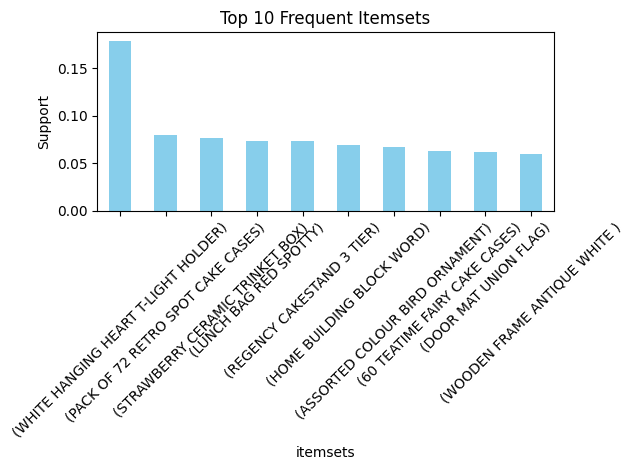

In [ ]:
plt.figure(figsize=(10, 6))
frequent_itemsets.sort_values('support', ascending=False).head(10).plot(
    x='itemsets', y='support', kind='bar', legend=False, color='skyblue')
plt.title("Top 10 Frequent Itemsets")
plt.ylabel("Support")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## B. Heatmap of correlations (top 20 items)


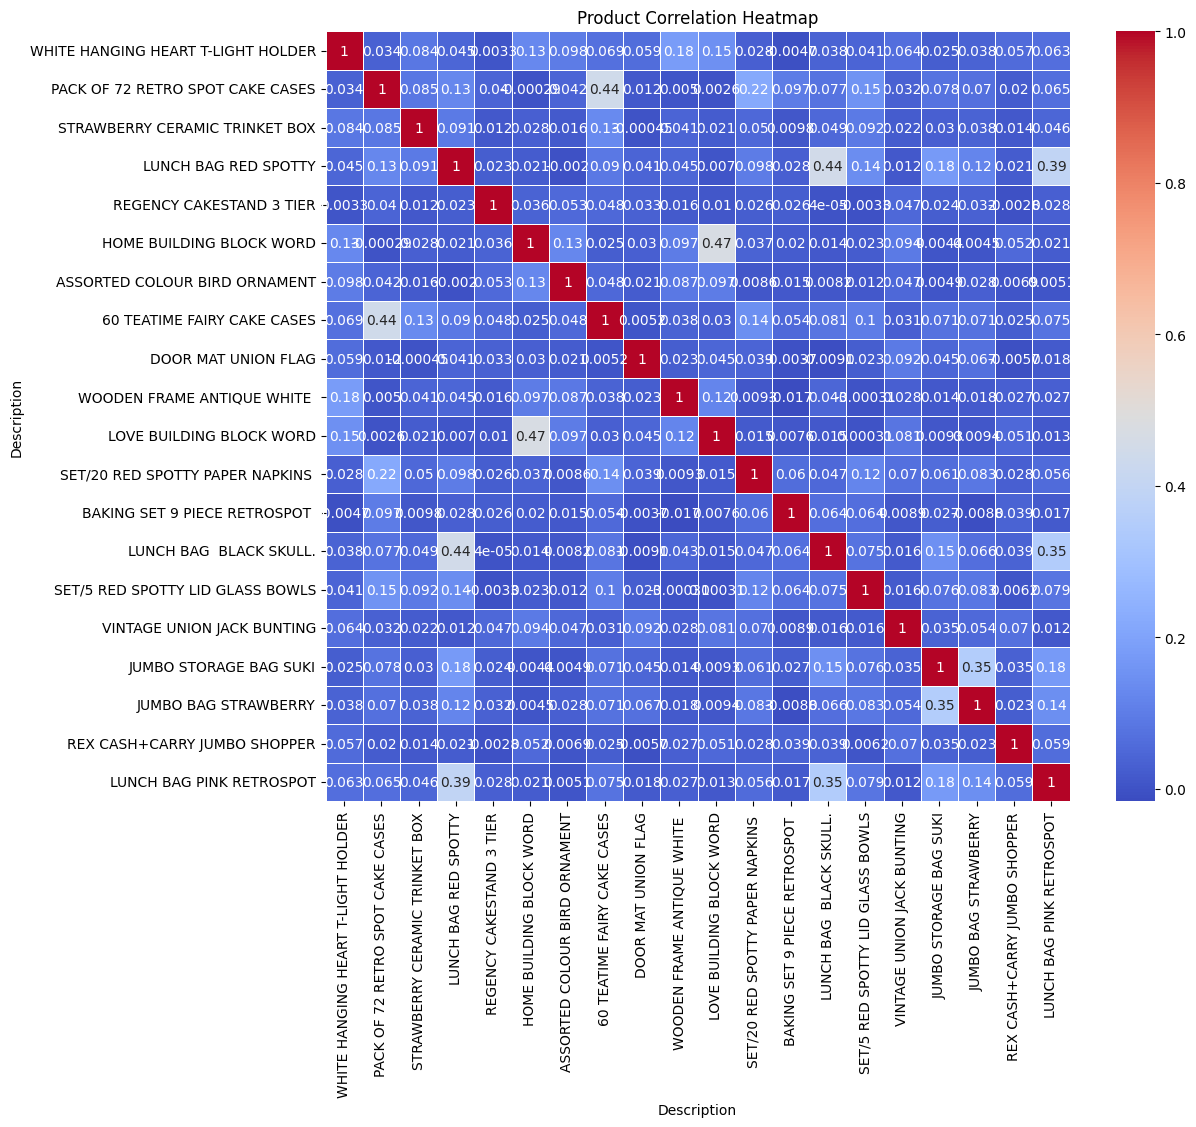

In [ ]:
top_items = basket_sets.sum().sort_values(ascending=False).head(20).index
corr = basket_sets[top_items].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Product Correlation Heatmap")
plt.show()


## C. Scatter plot of support vs confidence


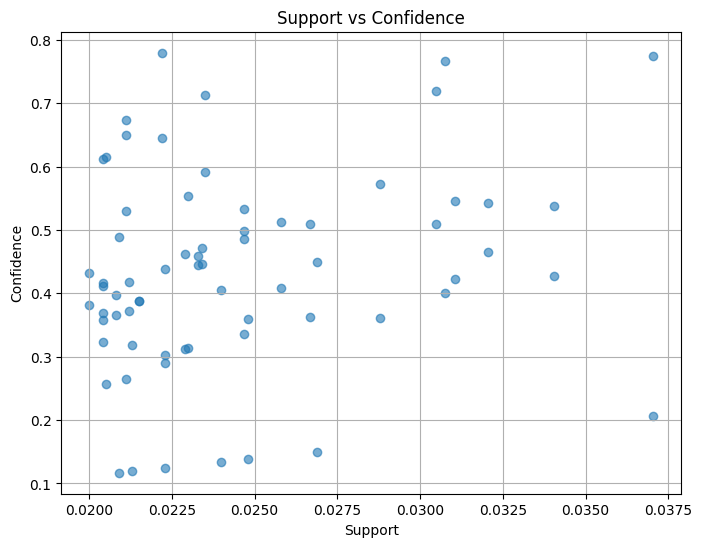

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.6)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.grid(True)
plt.show()


## D. Network graph of rules

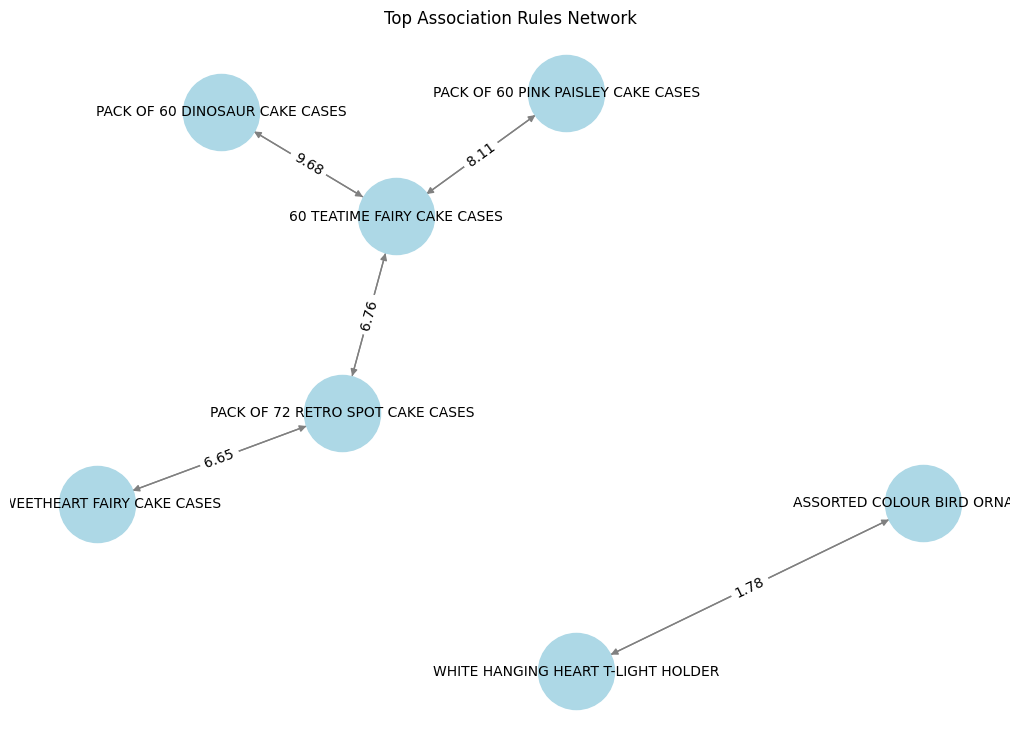

In [ ]:
G = nx.DiGraph()
for _, row in rules.head(10).iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['lift'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=1.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000,
        font_size=10, edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
plt.title('Top Association Rules Network')
plt.show()


# Step 7: Recommend Products


In [ ]:
def recommend_products(rules_df, product_name):
    recommendations = rules_df[rules_df['antecedents'].apply(lambda x: product_name in x)]
    return recommendations[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False)



In [ ]:
recommendation_result = recommend_products(rules, 'WHITE HANGING HEART T-LIGHT HOLDER')
print("Recommendations:")
print(recommendation_result)


Recommendations:
                             antecedents                         consequents  \
58  (WHITE HANGING HEART T-LIGHT HOLDER)  (RED HANGING HEART T-LIGHT HOLDER)   
14  (WHITE HANGING HEART T-LIGHT HOLDER)           (CREAM HEART CARD HOLDER)   
64  (WHITE HANGING HEART T-LIGHT HOLDER)       (WOODEN FRAME ANTIQUE WHITE )   
26  (WHITE HANGING HEART T-LIGHT HOLDER)          (LOVE BUILDING BLOCK WORD)   
20  (WHITE HANGING HEART T-LIGHT HOLDER)          (HOME BUILDING BLOCK WORD)   
8   (WHITE HANGING HEART T-LIGHT HOLDER)     (ASSORTED COLOUR BIRD ORNAMENT)   
63  (WHITE HANGING HEART T-LIGHT HOLDER)    (STRAWBERRY CERAMIC TRINKET BOX)   

     support  confidence      lift  
58  0.037041    0.207242  4.336114  
14  0.020910    0.116992  2.738804  
64  0.026884    0.150418  2.517744  
26  0.023997    0.134262  2.270020  
20  0.024793    0.138719  2.010320  
8   0.021308    0.119220  1.784392  
63  0.022304    0.124791  1.625521  


 # Step 8: Customer Segmentation (RFM Analysis & Clustering)

# Calculate Monetary: Total spending per customer (already filtered for Quantity > 0)

In [ ]:
monetary_df = df.groupby('Customer ID')['Quantity'].sum().reset_index()
monetary_df.rename(columns={'Quantity': 'Monetary'}, inplace=True)


# Calculate Frequency: Number of unique invoices per customer

In [ ]:
frequency_df = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
frequency_df.rename(columns={'Invoice': 'Frequency'}, inplace=True)

#Calculate Recency: Days since last purchase
# Calculate the latest date in the dataset and add one day to it

In [ ]:
latest_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

recency_df = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (latest_date - recency_df['InvoiceDate']).dt.days
recency_df = recency_df[['Customer ID', 'Recency']]


# Merge the RFM components into a single DataFrame

In [ ]:
rfm = monetary_df.merge(frequency_df, on='Customer ID').merge(recency_df, on='Customer ID')

In [ ]:
print("RFM DataFrame Head:")
print(rfm.head())
print("\nRFM DataFrame Info:")
rfm.info()
print("\nRFM DataFrame Description:")
print(rfm.describe())

RFM DataFrame Head:
   Customer ID  Monetary  Frequency  Recency
0      12346.0     74285         12      326
1      12347.0      3286          8        2
2      12348.0      2714          5       75
3      12349.0      1624          4       19
4      12350.0       197          1      310

RFM DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5881 non-null   float64
 1   Monetary     5881 non-null   int64  
 2   Frequency    5881 non-null   int64  
 3   Recency      5881 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 183.9 KB

RFM DataFrame Description:
        Customer ID       Monetary    Frequency      Recency
count   5881.000000    5881.000000  5881.000000  5881.000000
mean   15314.674205    1822.975854     6.287196   201.457745
std     1715.429759    8968.636988    13.012879   209.474135
min    

 # Step 8: Clustering using KMeans on Scaled RFM Data

# Prepare data for clustering (drop Customer ID for scaling)

In [ ]:
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]

# Scale the RFM data
# Initialize StandardScaler

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)


# Determine the optimal number of clusters using the Elbow Method

In [ ]:
inertia = []
# Try a range of cluster numbers, e.g., 1 to 10
k_range = range(1, 11)
for n_clusters in k_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph

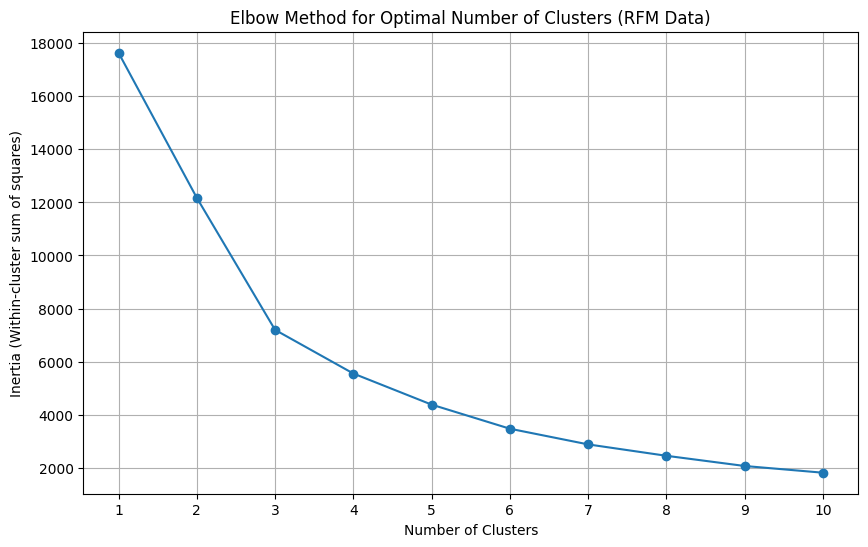

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal Number of Clusters (RFM Data)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


# Step 9: Visualize Clusters using PCA components

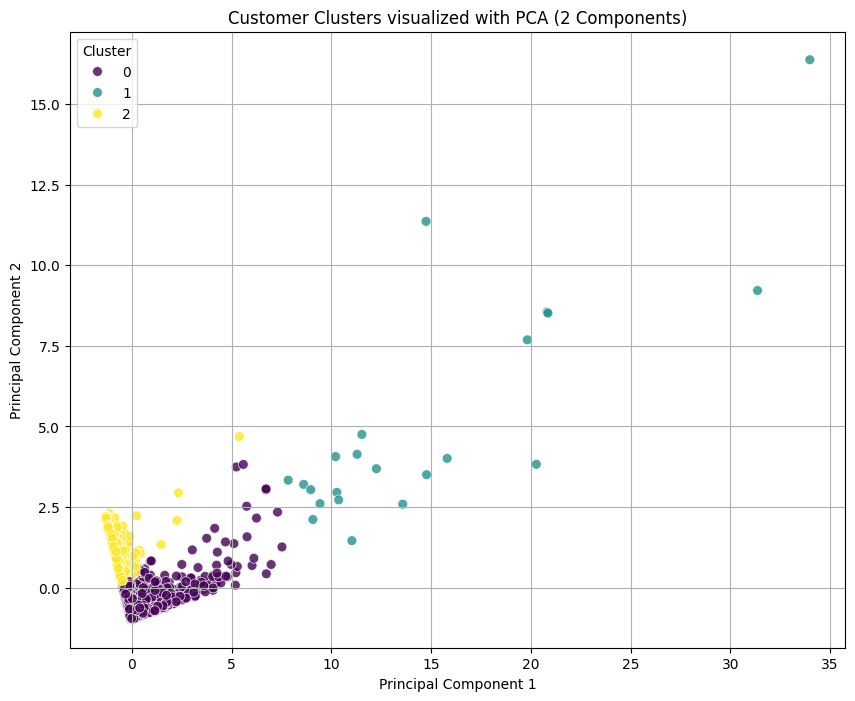

In [ ]:
optimal_clusters = 3 # Choose the optimal number of clusters from the Elbow method
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled)
# ------------------------

# Add PCA components back to the rfm DataFrame for plotting
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Visualize Clusters using PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm, palette='viridis', s=50, alpha=0.8)
plt.title('Customer Clusters visualized with PCA (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()